# Data description

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [ ]:
con = sqlite3.connect("test.db")

data = pd.read_sql_query('SELECT * FROM history', con)

con.close()

In [ ]:
data.head()

,issue_key,status,minutes_in_status,previous_status,started_at,ended_at
0,C-40460,Open,113.0,None,1669363867000,1.669371e+12
1,C-40460,In Progress,6289.0,Open,1669370640119,1.669748e+12
2,C-40460,In Review,2484.0,In Progress,1669747964986,1.669897e+12
3,B-7067,Closed,NaN,Test,1668583633246,NaN
4,B-6168,In Progress,187.0,Open,1655891591619,1.655903e+12


    history

    issue_key – уникальный ключ задачи
    status – статус задачи
    minutes_in_status – количество минут, которое задача находилась в статусе
    previous_status – предыдущий статус задачи
    started_at – время создания статуса задачи, unix миллисекунды 
    ended_at – время перехода задачи в другой статус, unix миллисекунды 


In [ ]:
len(data)

11560

In [ ]:
data.dtypes

issue_key             object
status                object
minutes_in_status    float64
previous_status       object
started_at             int64
ended_at             float64
dtype: object

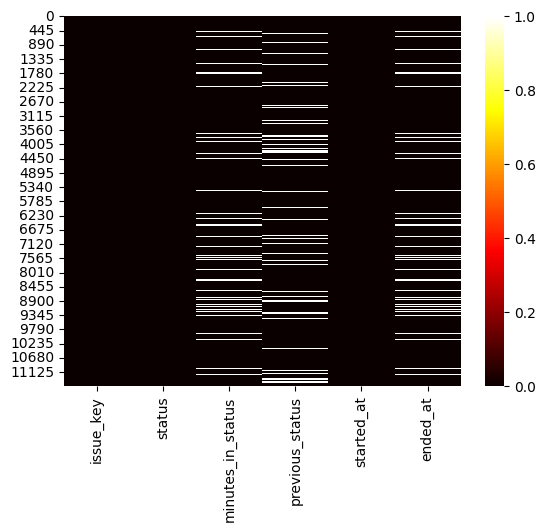

In [ ]:
sns.heatmap(data.isnull(), cmap='hot')
plt.show()

In [ ]:
data.isna().sum()

issue_key               0
status                  0
minutes_in_status    1378
previous_status      1378
started_at              0
ended_at             1378
dtype: int64

In [ ]:
con = sqlite3.connect("test.db")

status = pd.read_sql_query(\
'''
  SELECT status, COUNT(status)
  FROM history
  GROUP BY status
''', con)

con.close()

In [ ]:
con = sqlite3.connect("test.db")

prev_status = pd.read_sql_query(\
'''
  SELECT previous_status, COUNT(previous_status)
  FROM history
  GROUP BY previous_status 
''', con)

con.close()

In [ ]:
merged_stat = status.merge(prev_status, left_on='status', \
                           right_on='previous_status', how='left')
merged_stat[['status', 'COUNT(status)', 'COUNT(previous_status)']]

,status,COUNT(status),COUNT(previous_status)
0,Approved,36,36
1,Blocked,462,459
2,Build failed,40,40
3,Closed,1110,83
4,IN REVIEW,5,5
5,In Owl,566,561
6,In Progress,2603,2596
7,In Review,778,777
8,In Revision,33,33
9,In Testing,692,687


    Всевозможные варианты статусов и их количество.

In [ ]:
con = sqlite3.connect("test.db")

status_na = pd.read_sql_query(\
'''
  SELECT status, previous_status
  FROM history
  WHERE previous_status is NULL
''', con)

con.close()

In [ ]:
status_na

,status,previous_status
0,Open,None
1,Open,None
2,Open,None
3,Open,None
4,Open,None
...,...,...
1373,Open,None
1374,Open,None
1375,Open,None
1376,Open,None


In [ ]:
con = sqlite3.connect("test.db")

ended = pd.read_sql_query(\
'''
  SELECT status, previous_status, minutes_in_status, ended_at
  FROM history
  WHERE status = "Closed"
''', con)

con.close()

In [ ]:
ended

,status,previous_status,minutes_in_status,ended_at
0,Closed,Test,NaN,NaN
1,Closed,Resolved,NaN,NaN
2,Closed,Resolved,NaN,NaN
3,Closed,Resolved,NaN,NaN
4,Closed,Resolved,NaN,NaN
...,...,...,...,...
1105,Closed,Resolved,NaN,NaN
1106,Closed,Resolved,381.0,1.591021e+12
1107,Closed,Resolved,NaN,NaN
1108,Closed,Resolved,NaN,NaN


Missing values in 'minutes_in_status' and 'ended_at' are usually due to task closure. Empty values in 'previous_status' are associated with the opening of a task, where there is no previous status. Not all newly opened statuses have a previous status value of 'None'

In [ ]:
data

In [ ]:
data.duplicated().value_counts()

False    11560
dtype: int64

No duplicates

# Task SQL1

Write a query that will display the average time tasks from each group spend in the "Open" status.

Conditions:

By group, we mean the first character in the task key. For example, for the key "C-40460," the group would be "C."

A task can transition to the same status multiple times.

Convert the time to hours with rounding to two decimal places.

In [ ]:
con = sqlite3.connect("test.db")

SQL1 = pd.read_sql_query(\
'''
  WITH CTE AS
    (
      SELECT issue_key, 
        SUM(IFNULL(minutes_in_status, 0)) AS sum_min, 
          previous_status
      FROM history
      WHERE previous_status = "Open"
      GROUP BY issue_key
    )
  SELECT SUBSTR(issue_key, 1, 1) AS short_key, 
    ROUND((SUM(sum_min) / COUNT(SUBSTR(issue_key, 1, 1))*1.0) / 60, 2) AS open_hour
  FROM CTE
  GROUP BY short_key
  ORDER BY open_hour DESC
''', con)

con.close()

In [ ]:
SQL1

,short_key,open_hour
0,D,506.17
1,C,307.27
2,E,276.95
3,B,152.67
4,A,135.32


Initially, I replaced empty values with zero. Then I grouped the values by the issue key, summing all the time spent in the "Open" status. I removed the first letter from the key, grouped all the values by it, and found the average. I rounded the time to two decimal places.

As observed, the average resolution time for tasks in group D is higher than that for tasks in all other groups.

# Задание SQL2

Write a query that will display the task key, the last status, and its creation time for tasks that are currently open.

Conditions:

Tasks are considered open if their last status at the given moment is not "Closed" or "Resolved."

A task can transition to the same status multiple times.

Format the query in such a way that by changing the date, it can be used to search for open tasks at any point in the past.

Convert the time to textual representation.

In [ ]:
con = sqlite3.connect("test.db")

SQL2 = pd.read_sql_query(\
'''
  WITH CTE2 AS
    (
      WITH CTE AS
        (
          SELECT *, 
            ROW_NUMBER() OVER(PARTITION BY issue_key ORDER BY ended_at) AS max,
              ROW_NUMBER() OVER(PARTITION BY issue_key ORDER BY started_at) AS min
          FROM history
        )
      SELECT *
      FROM CTE
      WHERE max = 1 OR min = 1
    )
  SELECT t1.issue_key, t1.status, DATETIME(t2.started_at/1000,'unixepoch') AS date
  FROM CTE2 t1
  INNER JOIN (SELECT issue_key, started_at FROM CTE2 WHERE min = 1) t2
  ON t1.issue_key = t2.issue_key
  WHERE max = 1 AND status != "Closed" AND status != "Resolved"
''', con)

con.close()

In [ ]:
SQL2

,issue_key,status,date
0,A-31053,Open,2020-10-21 15:08:13
1,A-32133,Open,2021-04-29 09:55:29
2,A-37761,In Owl,2021-12-23 09:07:37
3,A-42030,Open,2022-04-20 09:30:29
4,A-44107,In Owl,2022-06-08 13:26:25
5,A-44901,In Owl,2022-06-28 12:10:38
6,A-44916,Blocked,2022-06-28 13:34:32
7,A-47808,Reopened,2022-08-18 11:52:34
8,A-49140,Reopened,2022-09-07 10:33:35
9,A-49829,In Review,2022-09-20 13:18:21


Filtered each task group using two window functions for the end date and the start date, where max 1 is the last status of the task, and min 1 is the first status of the task. Then, I joined the two created tables based on the issue key to extract the start date of the task. In the end, everything was filtered.

As a result, we obtained 40 rows of unresolved tasks.

# Python Task

The Python assignment is in another file.